[File colab link](https://colab.research.google.com/drive/1bXbzJgUoGeIM_7EMgnh6p-UsvAkRY8Tj#scrollTo=31EWlxEpDA_b)

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import torch
import torch.nn as nn
import torchvision
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch.optim as optim

import traceback

In [2]:
DEBUG=True
batch_size=128
shuffle_flag=False if DEBUG else False
train_data=torchvision.datasets.MNIST("./data",train=True,download=True,transform=torchvision.transforms.ToTensor())
test_data=torchvision.datasets.MNIST("./data",train=False,download=True,transform=torchvision.transforms.ToTensor())
train_loader=DataLoader(train_data,batch_size=batch_size,shuffle=shuffle_flag)
test_loader=DataLoader(test_data,batch_size=batch_size,shuffle=shuffle_flag)

Text(0.5, 1.0, 'digit 5')

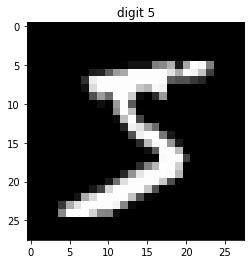

In [3]:
plt.imshow(train_data.data[0].detach().numpy(),cmap="gray")
plt.title("digit {}".format(train_data.targets[0].detach().numpy()))

## Create network

In [4]:
class ConvNet(nn.Module):
  def __init__(self,in_feature_2d,out_feature):
    self.in_feature_2d=in_feature_2d
    super(ConvNet,self).__init__()
    self.layer_2d=[]
    self. _set_network(in_feature_2d,out_feature) # Internal protected method

  def _set_network(self,in_feature_2d,out_feature):
    self.conv1=nn.Conv2d(in_channels=1,out_channels=16,kernel_size=(5,5),stride=1,padding="same")
    self.layer_2d.append(self.conv1)

    self.act1=nn.ReLU()
    self.layer_2d.append(self.act1)

    self.pooling1=nn.MaxPool2d(kernel_size=(2,2),stride=2)
    self.layer_2d.append(self.pooling1)

    self.conv2=nn.Conv2d(in_channels=16,out_channels=32,kernel_size=(3,3),padding="same")
    self.layer_2d.append(self.conv2)

    self.act2=nn.ReLU()
    self.layer_2d.append(self.act2)

    self.pooling2=nn.MaxPool2d(kernel_size=(2,2),stride=2)
    self.layer_2d.append(self.pooling2)

    self.conv3=nn.Conv2d(in_channels=32,out_channels=32,kernel_size=(3,3),padding="same")
    self.layer_2d.append(self.conv3)

    self.act3=nn.ReLU()
    self.layer_2d.append(self.act3)

    self.pooling3=nn.MaxPool2d(kernel_size=(7,7)) # global max pooling with pooling size of the input
    self.layer_2d.append(self.pooling3)

    self.featureFC=nn.Linear(in_features=32,out_features=2,bias=True)
    self.outputFC=nn.Linear(in_features=2,out_features=out_feature,bias=True)
  
  def forward(self,x):
    feature=self.feature_extraction(x)
    return self.outputFC(feature)
  
  def feature_extraction(self,x):
    input=x
    for layer in self.layer_2d:
      output=layer(input)
      input=output
    output=self.featureFC(output.squeeze())
    return output
  
  def predict_prob(self,x):
    output=self.forward(x)
    return output.softmax(dim=1) # apply softmax to each row, each batch
  
  def predict(self,x):
    prob=self.predict_prob(x)
    return prob.argmax(dim=1)

class MLPNet(nn.Module):
  def __init__(self,in_feature_2d,out_feature):
    self.in_feature_2d=in_feature_2d
    super(MLPNet,self).__init__()
    self.layers=nn.Sequential([
    nn.Linear(in_features=in_feature_2d[0]*in_feature_2d[1],out_features=200),
    nn.Linear(in_features=200,out_features=200),
    nn.Linear(in_features=200,out_features=10)
    ])

  
  def forward(self,x):
    return self.layers(x)
  
  def predict_prob(self,x):
    output=self.forward(x)
    return output.softmax(dim=1) # apply softmax to each row, each batch
  
  def predict(self,x):
    prob=self.predict_prob(x)
    return prob.argmax(dim=1)

In [5]:
input_size_2d=np.array(train_data.data[0].shape)

In [6]:
# model=ConvNet(input_size_2d,10)
model_MLP=ConvNet(input_size_2d,10)

In [7]:
lr=0.1
EPOCHES=20

In [8]:
optimizer=optim.SGD(model_MLP.parameters(),lr=lr)
loss_func=nn.CrossEntropyLoss()

In [9]:
def train( model, train_loader, test_loader, optimizer, loss_func, EPOCHES, device=torch.device("cpu")):
    model.to(device)
    model.train()
    train_loss_recorder = []
    lr_recorder = []
    for epoch in range(EPOCHES):
        avg_loss = 0
        for batch_idx, (data, target) in enumerate(train_loader):
            data = data.to(device)
            target = target.to(device)

            optimizer.zero_grad()  # clear all grad to avoid cumulation of grad
            output = model(data)
            loss_val = loss_func(output, target)
            avg_loss += loss_val.item()
            loss_val.backward()
            optimizer.step()

            if batch_idx % 100 == 0:
                print(
                    "Train Epoch:{}/{} [{}/{} ({:.0f}%)] \t Loss: {:.6f}\r".format(
                        epoch + 1,
                        EPOCHES,
                        batch_idx * len(data),
                        len(train_loader.dataset),
                        100 * (batch_idx / len(train_loader)),
                        loss_val.item(),
                    ),
                    end="",
                )


        avg_loss = avg_loss / (len(train_loader))
        train_loss_recorder.append([epoch, avg_loss])
        lr_recorder.append([epoch, optimizer.param_groups[0]["lr"]])
        if epoch % 20 ==0:
            print(
                "Train Epoch:{}/{} \t Average Loss: {:.6f}\r".format(
                    epoch+1, EPOCHES, avg_loss
                )
            )
            torch.save(model.state_dict(), "model_epoch_{}.pth".format(epoch))
            torch.save(optimizer.state_dict(), "optimizer_epoch_{}.pth".format(epoch))
        torch.save(model.state_dict(), "model_epoch_{}.pth".format(epoch))
        torch.save(optimizer.state_dict(), "optimizer_epoch_{}.pth".format(epoch))
    return {"loss": {"train_loss": train_loss_recorder}, "lr": lr_recorder}



In [11]:
recorded_message=train(model_MLP,train_loader,test_loader,optimizer,loss_func,5)

Train Epoch:1/5 	 Average Loss: 0.626137ss: 0.392555


In [16]:
recorded_message["loss"]

{'train_loss': [[0, 0.6261366317267103],
  [1, 1.5594750660568921],
  [2, 0.6269161657356759],
  [3, 0.46938257842366377],
  [4, 0.35254062745553344]]}

In [17]:
class TestTools():
    registered_service={}
    def __init__(self) -> None:
        pass
    @classmethod
    def accuracy_rate(cls,model,data,targets):
        cls.registered_service["accuracy"]=cls.accuracy_rate # not work as hope
        model.eval()
        with torch.no_grad():
            result=model.predict(data.reshape(-1,1,28,28).float())
        return (torch.sum(result==targets).item()/len(train_data))
    @classmethod
    def loss(cls,model,loss_func,data,targets):
        cls.registered_service["loss"]=cls.loss
        model.eval()
        with torch.no_grad():
            data=data.reshape(-1,1,28,28).float()
            output=model(data)
            loss_val=loss_func(output,targets)
        return loss_val.item()

In [18]:
with torch.no_grad():
  result=model.predict_prob(train_data.data.reshape(-1,1,28,28).float())

NameError: name 'model' is not defined

In [19]:
TestTools.accuracy_rate(model_MLP,train_data.data[:64],train_data.targets[:64])
TestTools.loss(model_MLP,loss_func,train_data.data[:64],train_data.targets[:64])


1414.86767578125

In [21]:
model_MLP2=MLPNet(input_size_2d,10).load_state_dict(torch.load(r"C:\Users\20211575\Downloads\Workspace\ProjectComputerVisionAnd3DImageProcessing\ReIDProj\model_epoch_4.pth"))

TypeError: list is not a Module subclass